# Google News Extraction and Topic Modelling

Use of Pygooglenews to obtain urls based on Google query search. Also use of Googlsearch to produce list of URLs in the main search query of Google. Download sentences from urls with Article / Newspaper3k and preprocessing to remove special characters. Further removal of similar sentences by looking at cosine similarity which yields a large list of sentences that are unique by a certain threshold with respect to the query search.

Then, preprocessing and cleaning of text; reproduced in large list form and also dataframe form split by a particular category or date.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install sentence_transformers

In [ ]:
!pip install newspaper3k

In [ ]:
!pip install BERTopic

In [ ]:
!pip install pygooglenews

In [2]:
# from sentence_transformers import SentenceTransformer, util
# from googlesearch import search
# from newspaper import Article
# from bertopic import BERTopic
from nltk import tokenize
from tqdm import tqdm
import nltk
import re

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**We use pygooglenews to extract news articles for a particular topic to generate sentences based on current affairs.**

In [ ]:
from pygooglenews import GoogleNews

In [ ]:
gn = GoogleNews()

In [ ]:
search = gn.search('ethereum', when = '6m')

In [ ]:
entries = search['entries']

In [ ]:
entries_list = [entries[i]['link'] for i in range(len(entries))]
date_list = [entries[i]['published'] for i in range(len(entries))]
data_tuples = list(zip(date_list, entries_list))
news_data = pd.DataFrame(data_tuples, columns=['Date', 'URL'])
news_data

,Date,URL
0,"Mon, 21 Mar 2022 17:01:17 GMT",https://www.benzinga.com/markets/cryptocurrenc...
1,"Tue, 15 Mar 2022 07:00:00 GMT",https://www.coindesk.com/business/2022/03/15/4...
2,"Wed, 02 Mar 2022 08:00:00 GMT",https://www.coindesk.com/layer2/2022/03/02/wha...
3,"Sat, 19 Mar 2022 11:31:16 GMT",https://ambcrypto.com/from-a-6m-buy-in-to-30k-...
4,"Thu, 03 Mar 2022 08:00:00 GMT",https://www.fxempire.com/news/article/ukrained...
5,"Thu, 24 Mar 2022 04:35:00 GMT",https://www.coindesk.com/markets/2022/03/24/fi...
6,"Sat, 12 Mar 2022 08:00:00 GMT",https://www.coindesk.com/policy/2022/03/12/lim...
7,"Wed, 02 Mar 2022 08:00:00 GMT",https://cryptopotato.com/gal-gadot-participate...
8,"Fri, 05 Nov 2021 07:00:00 GMT",https://cryptobriefing.com/early-xcopy-nft-sel...
9,"Wed, 15 Sep 2021 07:00:00 GMT",https://seekingalpha.com/article/4455342-solan...


In [42]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Search in general search query, rather than news**

In [ ]:
from googlesearch import search

In [ ]:
def scrape_urls(query, num):
    urls = list(search(query, stop=num))
    return urls

urls = scrape_urls(query='web3', num=50)
len(urls)

In [ ]:
gen_data = pd.DataFrame(urls, columns=['URL'])

In [ ]:
gen_data.head(10)

,URL
0,https://en.wikipedia.org/wiki/Web3
1,https://en.wikipedia.org/wiki/Web_2.0
2,https://en.wikipedia.org/wiki/Gavin_Wood
3,https://en.wikipedia.org/wiki/Buzzword
4,https://en.wikipedia.org/wiki/Decentralized_fi...
5,https://www.weforum.org/agenda/2022/02/web3-tr...
6,https://web3.foundation/
7,https://web3.foundation/about/
8,https://web3.foundation/projects/
9,https://web3.foundation/grants/


## Extraction from URL List

Obtain sentences from URL list. Data preprocessing with regex to remove special characters, new lines and optionally further cleaning to remove stop words and short words. Additional pandas operations to generate dataframe of sentences split by date or any category.

In [ ]:
def GetSentences(url):

    try:
      article = Article(url)
      article.download()
      article.parse()
    except:
      pass
    if article:
      sentences = tokenize.sent_tokenize(article.text)
      sentences = [re.sub(r'web','',sentence) for sentence in sentences]
      sentences = [re.sub(r'[^A-Za-z0-9 ]+','',sentence) for sentence in sentences]
      sentences = [re.sub('\n ', '', sentence) for sentence in sentences]
      sentences = [re.sub('\n', ' ', sentence) for sentence in sentences]
      sentences = [sentence for sentence in sentences if len(sentence) > 20]
      duplicates = list(set([s for s in sentences if sentences.count(s) > 1]))
      cleaned_sentences = list(set(sentences))
      
      return cleaned_sentences

SentenceTransformer library to get a vector representation of the text and then compute its similarity to other sentences. Remove if "similar" past a threshold.

In [ ]:
def RemoveSimilarSentences(sentences, model, similarity_threshold):

    new_sentences = sentences.copy()
    embeddings = model.encode(new_sentences, show_progress_bar=False)
    
    # Compute cosine-similarities for each sentence with each other sentence
    cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)
    # Find most similar pairs
    pairs = []
    for i in range(len(cosine_scores)-1):
        for j in range(i+1, len(cosine_scores)):
            pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})
    # Get similar pairs
    similar = []
    for pair in pairs:
      if pair['score'] > similarity_threshold:
        similar.append(pair['index'])
    # Get indeces of similar pair
    del_indices = []
    for i in similar:
      del_indices.append(min(i))
    del_indices = set(del_indices)
    # Delete similar sentences
    try:
      for i in del_indices:
        del new_sentences[i]
    except:
      pass
    return new_sentences

In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
threshold = 0.7

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def GetDocuments(dataframe):

    documents = []
    sent_dict = {}
    dataframe = dataframe.reset_index()
    for i in range(len(dataframe)):
        sentences = GetSentences(dataframe.loc[i,'URL'])
        new_sentences = RemoveSimilarSentences(sentences, model, .65)
        sent_dict[dataframe.loc[i,'Date']] = new_sentences
        documents.append(new_sentences)

    flat_list = [i for sub_list in documents for i in sub_list]

    return flat_list, sent_dict

With the functions defined, we create lists and dataframes of news articles and articles from main search function on any particular topic. Dataframe by article or date is useful to analyse themes, sentiment and keywords by those categories and the overall list provides a more holistic set of data on this search query to analyse.

In [ ]:
news_data = news_data.reset_index()
sent_list, news_data_dict = GetDocuments(news_data)
print('total number of sentences:', len(sent_list))
news_df = pd.DataFrame(news_data_dict.items(), columns=['Date', 'Sent'])

total number of sentences: 335


In [ ]:
gen_data['Date'] = np.arange(len(gen_data))
gen_sent_list, gen_data_dict = GetDocuments(gen_data)
print('total number of sentences:', len(gen_sent_list))
gen_df = pd.DataFrame(gen_data_dict.items(), columns=['Date', 'Sent'])

total number of sentences: 1963


In [ ]:
gen_df.head(10)

,Date,Sent
0,0,[ Web is generally considered to have begun a...
1,1,[Edit box interface through which anyone could...
2,2,[He also served as the Ethereum Foundations fi...
3,3,"[The Journal of Technology Transfer, Loughlin ..."
4,4,[Handling the risks presented by cryptoassets ...
5,5,[It seems to know everything about us our lik...
6,6,[We fund research and development teams who ar...
7,7,[Examples would include Status MetaMask or MyC...
8,8,[Kusama is a scalable development network buil...
9,9,[Grant recipients should not be considered par...


## Additional Text Cleaning

As defined in other notebooks; need to consider the subsequent models employed. E.g. when trying to model topics or extractively summarise text based on grammatical structure or part-of-speech, it is important to preserve stop words, lemmatisation and stemming. Whereas if the model is, say, based on frequency of certain words or an abstrative summarisation tool, then we can preprocess the text further.

In [45]:
stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
def TextCleaner(text):
    newString = text.lower()
    tokens = [w for w in newString.split() if w not in stopwords]
    long_words = []
    prev_word = []
    for i in tokens:
        if i not in prev_word and len(i) >= 3:  # removing short word
            long_words.append(i)
            prev_word = [i]
    return (" ".join(long_words)).strip()

In [ ]:
sent_list_clean = [TextCleaner(sent) for sent in gen_sent_list]

In [ ]:
sent_list_clean[:10]

['web generally considered begun around continues current day',
 'technology scholars argued web3 would likely run tandem web sites web sites likely adopting web3 technologies order keep services relevant',
 'decentralized finance defi another key concept users exchange currency without bank government involvement',
 'november ceo jason citron tweeted screenshot suggesting discord might exploring integrating crypto wallets platform',
 'spacex tesla ceo elon musk expressed skepticism web3 tweet saying web3 seems marketing buzzword reality right',
 'others elon musk jack dorsey argued web3 currently serves buzzword',
 'terminology edit web3 distinct tim bernerslees concept semantic web',
 'reception edit technologists journalists described web3 possible solution concerns overcentralization web big tech companies',
 'bernerslee described semantic web component web different term web3 crypto context',
 'critics web3 see concept part cryptocurrency bubble extension blockchainbased trends se

In [ ]:
gen_df = gen_df.explode('Sent')

In [ ]:
gen_df = gen_df.dropna()

In [ ]:
gen_df['Sent_clean'] = gen_df['Sent'].apply(lambda x : TextCleaner(x))

**Save url list and sentence list.**

In [5]:
import pickle

In [4]:
save_path = "/content/drive/My Drive/NewsData"

In [ ]:
with open(save_path+"/27MarWeb3DF.pickle", 'wb') as handle:
    pickle.dump(gen_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(save_path+"/10MarRussia_url.pickle", 'wb') as handle:
    pickle.dump(entries_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
with open(save_path+"/27MarWeb3DF.pickle", 'rb') as handle:
    gen_df = pickle.load(handle)

# Topic / Keyword Modelling

Various techniques as explored in other notebooks and new ideas. A classical approach is through a statistical approach, based on word frequencies or consecutive words that appear several times. The following functions and tools will extract lists of words or phrases for each text in the series of text being considered. As seen in other notebooks, there are a variety of ways to build this but I have chosen to stick with the TF-IDF approach, for the intuitiveness of it and RAKE, due to experience on the accuracy as well as speed on larger sets of data.

## Statistical Approach - TF-IDF / RAKE

**Term Frequency** – How frequently a term occurs in a text. It is measured as the number of times a term t appears in the text / Total number of words in the document

**Inverse Document Frequency** – How important a word is in a document. It is measured as log(total number of sentences / Number of sentences with term t)

**RAKE** stands for Rapid Automatic Keyword Extraction. The score of each keyword, which is also called keyphrase because it contains several words, is based on two elements: the frequency of the words and the sum of their co-occurrences. 

In [34]:
gen_df2 = gen_df.drop(['Sent'], axis=1)

In [35]:
gen_df2 = gen_df.groupby(['Date'])['Sent_clean'].transform(lambda x : '. '.join(x))

In [36]:
gen_df2 = gen_df2.drop_duplicates()
gen_df2 = gen_df2.dropna()

In [37]:
gen_df2 = gen_df2.reset_index().drop(['index'], axis=1)

In [ ]:
gen_df2

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def SortCoo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [ ]:
def ExtractTopN(feature_names, sorted_items, topn=10):
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]
    return results

In [ ]:
def GetKeywords(content_list):
    keywords = []

    vectorizer = CountVectorizer(max_df = 0.85)
    sent_word_matrix = vectorizer.fit_transform(content_list)

    tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(sent_word_matrix)
    
    feature_names = vectorizer.get_feature_names()

    for i in range(len(content_list)):
        doc = content_list[i]
        tf_idf_vector = tfidf_transformer.transform(vectorizer.transform([doc]))
        sorted_items = SortCoo(tf_idf_vector.tocoo())
        keys = ExtractTopN(feature_names, sorted_items, 10)
        keywords.append(list(keys.keys()))
    
    return keywords

In [ ]:
gen_df_subset = pd.concat([gen_df2, pd.Series(GetKeywords(gen_df2['Sent_clean'].tolist()))], axis = 1)

In [ ]:
gen_df_subset = gen_df_subset.rename(columns={0: "TF-IDF KeyWords"})

In [ ]:
gen_df_subset.head(10)

,Sent_clean,TF-IDF KeyWords
0,web generally considered begun around continue...,"[web3, web, edit, concept, semantic, idea, des..."
1,edit box interface anyone could edit wikipedia...,"[web, content, sites, edit, social, usergenera..."
2,also served ethereum foundations first chief t...,"[wood, ethereum, polkadot, founded, edit, comp..."
3,journal technology transfer loughlin michael m...,"[buzzwords, buzzword, edit, business, students..."
4,handling risks presented cryptoassets already ...,"[defi, interest, cryptocurrency, loans, assets..."
5,seems know everything likes dislikes friends s...,"[web3, internet, personal, ownership, site, co..."
6,fund research development teams building found...,"[teams, fund, research, foundation, developmen..."
7,examples would include status metamask mycrypt...,"[developer, interact, user, userinterface, pro..."
8,kusama scalable development network built near...,"[codebase, innovate, scalable, nearly, kusama,..."
9,grant recipients considered partners polkadot ...,"[foundation, grants, software, steward, recipi..."


In [ ]:
gen_df_subset.drop(['Sent_clean'], axis=1)

,TF-IDF KeyWords
0,"[web3, web, edit, concept, semantic, idea, des..."
1,"[web, content, sites, edit, social, usergenera..."
2,"[wood, ethereum, polkadot, founded, edit, comp..."
3,"[buzzwords, buzzword, edit, business, students..."
4,"[defi, interest, cryptocurrency, loans, assets..."
5,"[web3, internet, personal, ownership, site, co..."
6,"[teams, fund, research, foundation, developmen..."
7,"[developer, interact, user, userinterface, pro..."
8,"[codebase, innovate, scalable, nearly, kusama,..."
9,"[foundation, grants, software, steward, recipi..."


In [ ]:
!pip install rake_nltk

In [ ]:
from rake_nltk import Rake
rake_nltk_var = Rake()

In [ ]:
def Rake(text):
    rake_nltk_var.extract_keywords_from_text(text)
    keyword_extracted = rake_nltk_var.get_ranked_phrases()
    return keyword_extracted

In [ ]:
gen_df_subset['Rake_keywords'] = gen_df_subset['Sent_clean'].apply(lambda x : Rake(x))

In [ ]:
gen_df_subset.drop(['Sent_clean'], axis=1)

Word **tokenization** with BertTokenizer for list of sentences and apply classical machine learning algorithms, such as XGBoost or Random Forest, against a classifier or unsupervised learning.

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
print(max([len(i.split()) for i in sent_list_clean]))

In [ ]:
tokens = []
for sent in sent_list_clean:
    sent_encoded = tokenizer.encode_plus(text=sent,
                                         pad_to_max_length=True,
                                         max_length='43',
                                         return_attention_mask=True)
    tokens.append(sent_encoded['input_ids'])

In [ ]:
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from numpy import unique
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

In [ ]:
# Simple K-means clustering
model = KMeans(n_clusters=10)
model.fit(np.array(tokens))

# XGBoost Classifer
param_grid = {'xgb__n_estimators': np.arange(10,310,30),
              'xgb__learning_rate': [0.1,0.15,0.2,0.3,0.4],
              'xgb__max_depth': [2,4,8,10,12],
              'xgb__colsample_bytree': [0.2,0.3,0.4],
              }
pipe = Pipeline([('xgb', xgb.XGBClassifer())])
xgb_model = RandomizedSearchCV(pipe, param_grid, cv=StratifiedKFold(N_splits=3), n_iter=200, verbose=2,
                               n_jobs=-1, scoring='roc_auc')
xgb_model.fit(X_tr, y_tr)

## Graph Approach - TextRank

TextRank algorithm is based on the same principles as the PageRank algorithm. However, instead of building a graph with pages and links, we will build a graph with words. Each word will be linked with other words according to their co-occurrence.

## BERTopic Modelling

BERTopic is a topic modeling technique that leverages transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

*   n_gram_range represents the minimum and the maximum number of words you want in the topic.

*   min_topic_size is the minimum number of sentences per topic.

*   nr_topics is the number of topics.

In [ ]:
model = BERTopic(n_gram_range=(1,3), 
                 min_topic_size=10,
                 nr_topics='auto')

In [ ]:
topics, probabilities = model.fit_transform(sent_list_clean)

In [ ]:
model.get_topic_freq()

In [ ]:
model.get_topics()

In [ ]:
model.visualize_topics()

In [ ]:
model.visualize_barchart(top_n_topics=21, n_words=3)

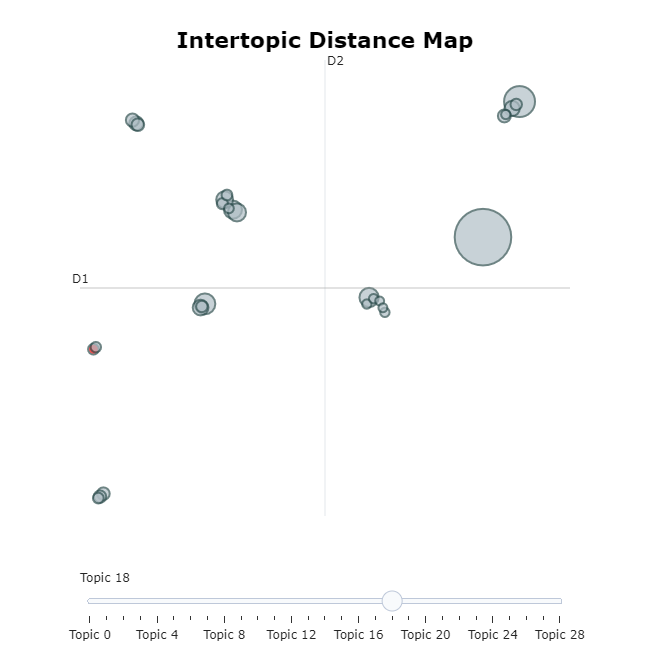

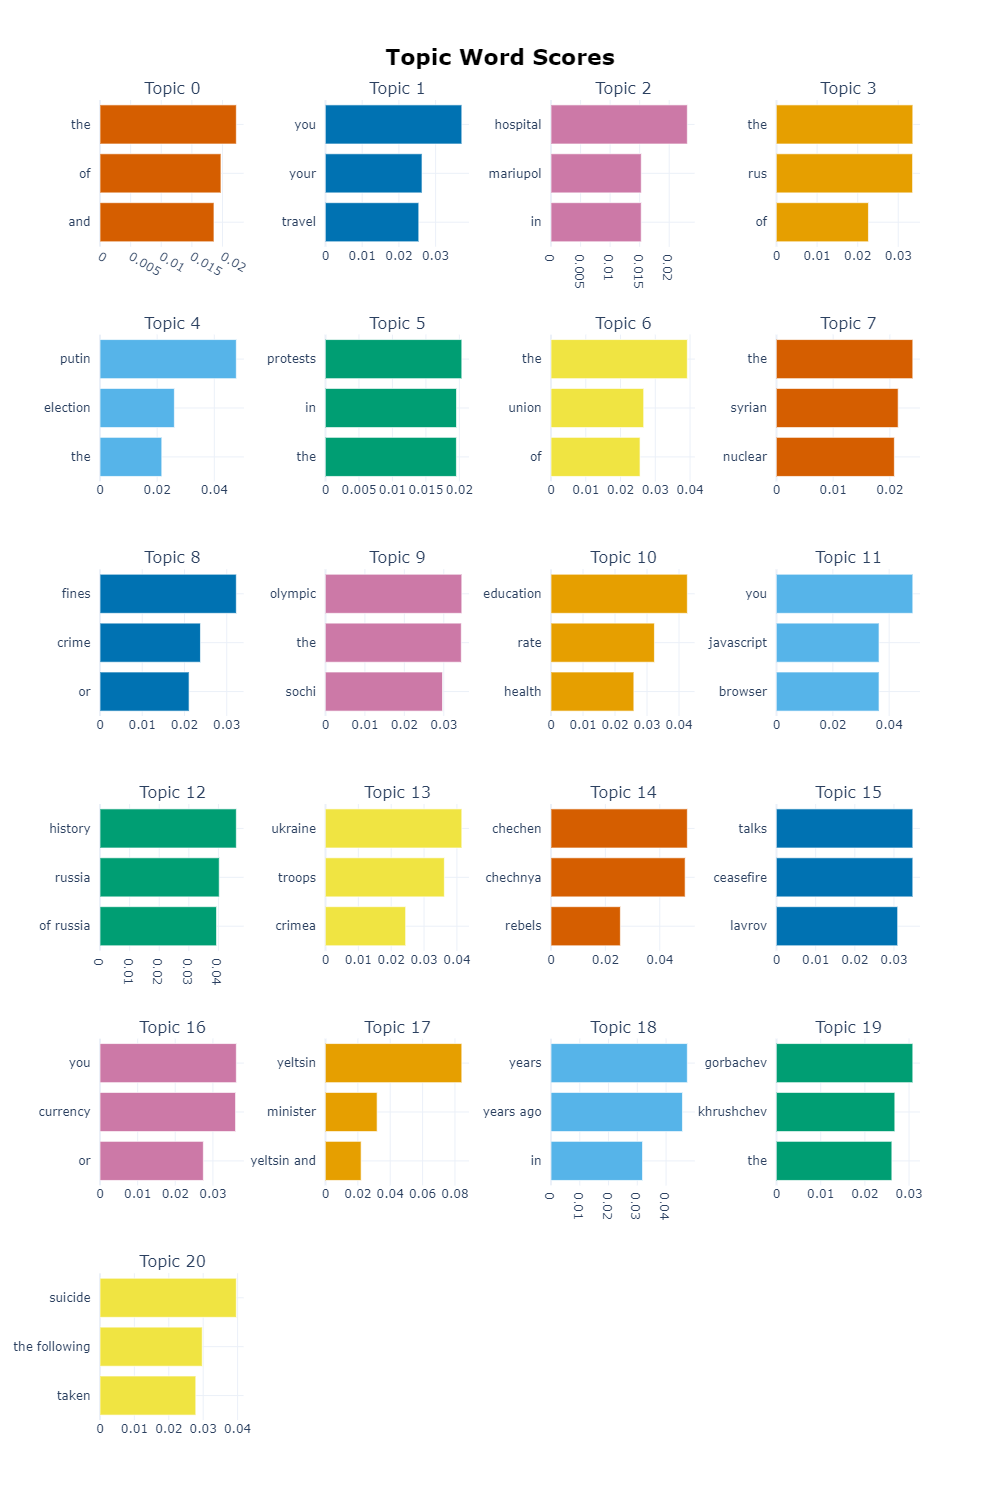

## Noun Phrase Analysis

In [ ]:
def EntitiesExtractor(dfcol1, dfcol2=[2022]*len(dfcol1)):
    """Search for nouns in each sentence / text, including for compound terms 
    where nouns appear consecutively and create dataframe by frequency"""
    
    noun_entities = []
    for sentence, date in zip(dfcol1, dfcol2):
        temp_noun_name = ''
        temp_noun_entity = None
        sentence = nlp(sentence)
        for word in sentence:
            term = word.text
            tag = word.pos_
            if tag == "NOUN":
                temp_noun_name = ' '.join([temp_noun_name, term]).strip()
                temp_noun_entity = (temp_noun_name, date)
            else:
                if temp_noun_entity:
                    noun_entities.append(temp_noun_entity)
                    temp_noun_name = ''
                    temp_noun_entity = None
          
    noun_df = pd.DataFrame(noun_entities)
    noun_df = noun_df.rename(columns={0:'Nouns', 1:'Date'})

    top_entities = (noun_df.groupby(by=['Nouns'])
                              .size()
                              .sort_values(ascending=False)
                              .reset_index().rename(columns={0 : 'Frequency'}))

    return top_entities.T.iloc[:,:15]

In [ ]:
EntitiesExtractor()

# Summarisation and Networks

Summarisation with TF-IDF centroid words to find sentences that are mostly closely associated with the centroid vector.

**Refer to functions in CompanyNLP notebook.**

In [46]:
import nltk
import re
import string
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize as nltk_sent_tokenize
from nltk.tokenize import word_tokenize as nltk_word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
import numpy as np
from scipy.spatial.distance import cosine

In [61]:
import sys
sys.path.append(save_path)

In [63]:
import TFIDFSummarizer
from TFIDFSummarizer import *

In [64]:
def Summarize(text, embedding_model):
    raw_sentences = SentTokenize(text) # tokenize sentence with NLTK
    clean_sentences = SentProcessing(text) # cleanup by removing stopwords, etc.

    centroid_words = GetTFIDF(clean_sentences) # centroid of all cleaned sentences (i.e. whole text)

    word_vectors = WordVectors(clean_sentences, embedding_model)

    centroid_vector = EmbeddingRep(centroid_words, word_vectors, embedding_model)

    sentences_scores = []
    for i in range(len(clean_sentences)):
        scores = []
        words = clean_sentences[i].split()
        sentence_vector = EmbeddingRep(words, word_vectors, embedding_model)
        # similarity between sentence embedding vector and centroid embedding vector
        score = Similarity(sentence_vector, centroid_vector)
        sentences_scores.append((i, raw_sentences[i], score, sentence_vector))
      
    sentence_scores_sort = sorted(sentences_scores, key=lambda x: x[2], reverse=True)

    count = 0
    sentences_summary = []

    # Handle redundancy
    for s in sentence_scores_sort:
        if count > 100:
            break
        include_flag = True
        for ps in sentences_summary:
            sim = Similarity(s[3], ps[3])
            if sim > 0.95:
                include_flag = False
        if include_flag:
            sentences_summary.append(s)
            count += len(s[1].split())

        sentences_summary = sorted(sentences_summary, key=lambda x: x[0], reverse=False)

    summary = " ".join([s[1] for s in sentences_summary])

    return summary

In [65]:
def PreprocessingSummarise(text):
    clean_sentences = SentProcessing(text)
    words = []
    for sent in clean_sentences:
        words.append(nltk_word_tokenize(sent))
    model = Word2Vec(words, min_count = 1, sg = 1)
    summary = Summarize(text, model)
    return summary

In [66]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
gen_df2['Summary'] = gen_df2['Sent_clean'].apply(lambda x : PreprocessingSummarise(x))

In [68]:
gen_df2.head(10)

,Sent_clean,Summary
0,web generally considered begun around continue...,november ceo jason citron tweeted screenshot s...
1,edit box interface anyone could edit wikipedia...,edit box interface anyone could edit wikipedia...
2,also served ethereum foundations first chief t...,also served ethereum foundations first chief t...
3,journal technology transfer. loughlin michael ...,loughlin michael may. makes management buzzwor...
4,handling risks presented cryptoassets already ...,inexperienced investors particular risk losing...
5,seems know everything likes dislikes friends s...,cryptocurrency incentivize participation distr...
6,fund research development teams building found...,fund research development teams building found...
7,examples would include status metamask mycrypt...,examples would include status metamask mycrypt...
8,kusama scalable development network built near...,kusama scalable development network built near...
9,grant recipients considered partners polkadot ...,grant recipients considered partners polkadot ...


Simple graph of sentences based on individual, unique words as nodes and consequtive words being an edge / relation between them.

In [69]:
import networkx as nx
import matplotlib.pyplot as plt

In [100]:
def WordList(document):
    sentences = [sent for sent in document.split('.') if sent != '']
    document = []
    for sent in sentences:
        words = sent.strip().split()
        document.append(words)
        
    return document

In [102]:
def BuildGraph(doc):
    doc = WordList(doc)

    nodes = Entities(doc)
    edges = Relations(doc)
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

In [103]:
def Entities(document):
    unique_words = []
    for sent in document:
        for word in sent:
            if word not in unique_words:
                unique_words.append(word)
    return unique_words

In [104]:
def Relations(document):
    bigrams = []
    for sent in document:
        for i in range(len(sent)-1):
            pair = [sent[i], sent[i+1]]
            if pair not in bigrams:
                bigrams.append(pair)
    return bigrams

In [105]:
G = BuildGraph(gen_df2['Summary'][3])

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

In [106]:
from networkx.drawing.nx_agraph import graphviz_layout

In [110]:
def PlotGraph(G):
    plt.figure(figsize=(10,10))
    
    pos = graphviz_layout(G)

    nx.draw(G, pos=pos, with_labels=True)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    plt.show()
    return

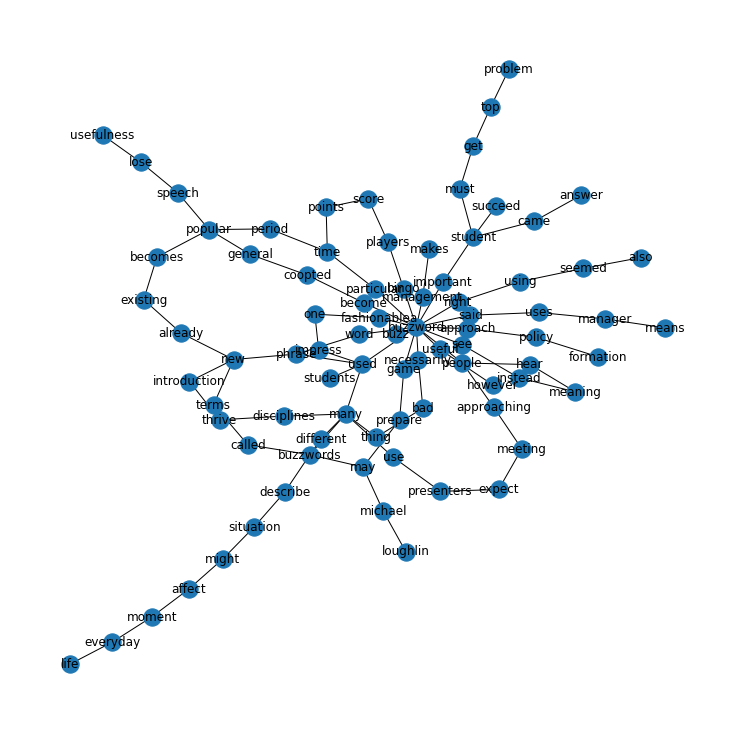

In [111]:
PlotGraph(G)

# News Topic Modelling from GDELT

GDELT using a Python package - articles are labelled with topics, personalities, and locations. We can examine the topic labelling by frequency over time to examine when certain topics are more frequently mentioned and when others are less frequently mentioned.

In [ ]:
!pip install gdelt
import gdelt
gd = gdelt.gdelt(version=1)

In [ ]:
root_folder = '/content/drive/My Drive/NewsData'

In [ ]:
import os
os.makedirs(root_folder, exist_ok=True)

In [ ]:
import datetime
cur_date = datetime.datetime(2022,3,13) - datetime.timedelta(days=60)
end_date = datetime.datetime(2022,3,13)

In [ ]:
while cur_date < end_date:
    print("%s-%s-%s"%(cur_date.year, cur_date.month, cur_date.day))
    if not os.path.exists("data/%s-%s-%s.pkl"%(cur_date.year, cur_date.month, cur_date.day)):

      year = cur_date.year
      month = str(cur_date.month)
      day = str(cur_date.day)
      
      if cur_date.month < 10:
        month = "0"+month
      if cur_date.day < 10:
        day = "0"+day

      results = gd.Search(['%s %s %s'%(year, month, day)],table='gkg',coverage=True, translation=False)
      results.to_pickle("data/%s-%s-%s.pkl"%(cur_date.year, cur_date.month, cur_date.day))

    cur_date+=datetime.timedelta(days=1)
    
    df = pd.DataFrame()

In [ ]:
k = os.listdir(root_folder)

In [ ]:
for i in k:
    print(i)
    if i.endswith(".pkl"):
      tmp = pd.read_pickle("data/"+i)
      tmp = tmp[tmp["SOURCES"].apply(lambda x: x in mySources)]
      df = pd.concat([df, tmp])
df.DATE = df.DATE.apply(lambda x: str(x))
df.DATE = pd.to_datetime(df.DATE)
df.fillna("", inplace=True)
df.set_index("DATE", drop=True, inplace=True)

In [ ]:
df["dprk"] = df["LOCATIONS"].apply(lambda x: x.find("North Korea") > -1)
df["ukraine"] = df["LOCATIONS"].apply(lambda x: x.find("Ukraine") > -1)
df["russia"] = df["LOCATIONS"].apply(lambda x: x.find("Russia") > -1)
df["iran"] = df["LOCATIONS"].apply(lambda x: x.find("Iran") > -1)
df["china"] = df["LOCATIONS"].apply(lambda x: x.find("China") > -1)

In [ ]:
loc_df = df.groupby(["SOURCES", "DATE"])[["dprk", "ukraine", "russia", "iran", "china"]].sum()

In [ ]:
mySources = ["nytimes.com", "washingtonpost.com", "foxnews.com", "cnn.com"]

In [ ]:
time_series = pd.DataFrame()
for publisher in mySources:
  time_series = pd.concat([time_series, loc_df.ix[publisher].add_prefix("{}_".format(publisher))], axis=1)

In [ ]:
mape_df = pd.DataFrame()
fig, axs = plt.subplots(4, 5, sharex=True)
fig.set_size_inches(16,12)
x = y = 0

In [ ]:
for issue in time_series:

    if issue.find(".com") < 0:
      continue

    train_l = len(time_series)-5

    selected_series = time_series[[col for col in time_series.columns if (col.find(issue[issue.find("_"):]) > -1)]]
    pub_series = time_series[[col for col in time_series.columns if (col.find(issue[:issue.find("_")]) > -1)]].drop(columns=issue)
    selected_series = selected_series.join(pub_series)

    s_model = SARIMAX(endog = selected_series[[issue]][:train_l][1:],
                      exog = selected_series[[x for x in selected_series.columns if x != issue]][:train_l].shift().add_suffix("_l1")[1:],
                      order=(3,1,1), seasonal_order=(1,0,1,7)).fit()


    f_ru = selected_series[[issue]].copy()[1:]
    f_ru.columns = ["actual"]
    f_ru["predicted"] = s_model.predict(end=datetime.datetime(2019, 10, 6), endog = selected_series[[issue]][-5:],exog = selected_series[[x for x in selected_series.columns if x != issue]].shift()[-5:], 
                                              dynamic= False)
    
    testing = f_ru.copy()

    testing["error"] = np.abs((testing["actual"] - testing["predicted"]) / testing["actual"])
    fit = round(testing[testing["actual"] != 0].error.mean()*100)
    
    mape_df.loc[issue, "NewspapersOnly_model"] = fit

    testing2 = testing[-5:]
    fit_p = round(testing2[testing2["actual"] != 0].error.mean()*100)
    mape_df.loc[issue, "NewspapersOnly_predicted"] = fit_p



    f_ru["actual"].plot(title="{}\nMAPE: test: {}% model: {}%".format(issue, fit_p, fit), ax=axs[x,y])
    f_ru["predicted"][:-5].plot(color="orange", label="predicted: Train", ax=axs[x,y])
    f_ru["predicted"][-6:].plot(color="red", label="predicted: Test", ax=axs[x,y])

    x+=1
    if x > 3:
        x =0
        y+=1

In [ ]:
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

fig.suptitle("News forecast using within publication and external topic")